In [1]:
!pip install kaggle

In [2]:
!mkdir ~/.kaggle/

In [3]:
# copy the api json path from drive
!cp "/content/drive/MyDrive/kaggle json/kaggle.json" ~/.kaggle/kaggle.json
# set permission to the file
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
# # API to fetch the dataset from Kaggle
!kaggle datasets download -d uditsharma72/real-vs-fake-faces

 91% 197M/215M [00:01<00:00, 194MB/s]
100% 215M/215M [00:01<00:00, 133MB/s]


In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [10]:
!mkdir fake_real_data

In [11]:
target_folder = '/content/fake_real_data'

In [13]:
# extracting the compessed Dataset
from zipfile import ZipFile
dataset = '/content/real-vs-fake-faces.zip'

with ZipFile(dataset,'r') as zip:
  zip.extractall(target_folder)
  print(f'The dataset is extracted to {target_folder}')

The dataset is extracted to /content/fake_real_data


In [14]:
dataset

'/content/real-vs-fake-faces.zip'

In [15]:
print(os.listdir('../content/fake_real_data'))

['real', 'fake']


In [16]:
for dirname, _, filenames in os.walk('/content/fake_real_data'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/content/fake_real_data/real/real_00097.jpg
/content/fake_real_data/real/real_00271.jpg
/content/fake_real_data/real/real_00718.jpg
/content/fake_real_data/real/real_00774.jpg
/content/fake_real_data/real/real_00009.jpg
/content/fake_real_data/real/real_01020.jpg
/content/fake_real_data/real/real_00384.jpg
/content/fake_real_data/real/real_00036.jpg
/content/fake_real_data/real/real_01057.jpg
/content/fake_real_data/real/real_01016.jpg
/content/fake_real_data/real/real_00624.jpg
/content/fake_real_data/real/real_00342.jpg
/content/fake_real_data/real/real_00059.jpg
/content/fake_real_data/real/real_00687.jpg
/content/fake_real_data/real/real_00518.jpg
/content/fake_real_data/real/real_00813.jpg
/content/fake_real_data/real/real_00968.jpg
/content/fake_real_data/real/real_00456.jpg
/content/fake_real_data/real/real_00481.jpg
/content/fake_real_data/real/real_00862.jpg
/content/fake_real_data/real/real_00806.jpg
/content/fake_real_data/real/real_00829.jpg
/content/fake_real_data/real/rea

In [17]:
!pip install tensorflow

In [18]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [19]:
# setting the image fixed size for training and intializing the batch size, channel and number of epochs
Image_Size= 256
Batch_Size = 32
Channels=3
Epochs=50

In [20]:
# determining number of pics and classes
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/fake_real_data",
    shuffle=True,
    image_size = (Image_Size,Image_Size),
    batch_size=Batch_Size

)

Found 2041 files belonging to 2 classes.


In [21]:
# above code creates
# This code creates a dataset of images using the Keras utility function image_dataset_from_directory.
# It reads images from a specified directory and organizes them into batches for training or validation.
# Here’s what each parameter means:
# This is the path to the directory containing your image data.
# The function will look for subdirectories within this path, where each subdirectory
# corresponds to a different class or label (e.g., “real” and “fake” faces).
# Images in each subdirectory will be treated as examples of that class.

In [29]:
class_names = dataset.class_names
class_names  # 0 means fake and 1 means real

['fake', 'real']

In [23]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[0 1 0 0 0 0 1 0 1 1 0 0 1 1 1 1 1 0 0 0 1 0 0 1 1 0 0 1 0 0 1 1]


In [27]:
# The above code iterates over the first batch of data from the dataset.
# The take(1) method ensures that only one batch is retrieved.
# Each batch contains a set of images and their corresponding labels.
# The .numpy() method converts the labels from TensorFlow tensors to NumPy
# arrays for easier printing.
# The labels correspond to the class names (“fake” or “real”) associated with each image

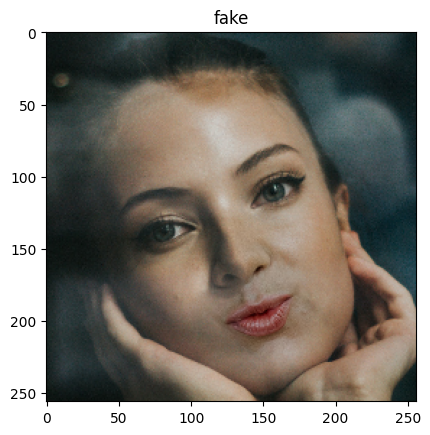

In [28]:
# Displaying our first image
for image_batch, label_batch in dataset.take(1):
    plt.imshow(image_batch[0].numpy().astype("uint8"))
    plt.title(class_names[label_batch[0]])

In [30]:
# function to create dataset

In [31]:
def splitting_dataset_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):

    ds_size=len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size=int(train_split * ds_size)
    val_size= int(val_split * ds_size)

    train_ds= ds.take(train_size)

    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [32]:
train_ds, val_ds, test_ds=splitting_dataset_tf(dataset)

In [33]:
print(len(train_ds),len(val_ds),len(test_ds))

51 6 7


In [35]:
#  Pipeline for Optimization for Training, Validation, and Testing Datasets
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [36]:
# Image Preprocessing for Resizing and Rescaling
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(Image_Size,Image_Size),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [37]:
# Data augmentation
data_aug = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),

])

In [38]:
# Architecture of the model
input_shape = (Batch_Size,Image_Size, Image_Size,Channels)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    data_aug,
    layers.Conv2D(32, (3,3), activation='relu', input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),


    layers.Flatten(),
    layers.Dense(64, activation = 'relu'),
    layers.Dense(n_classes, activation= 'softmax'),

])

model.build(input_shape=input_shape)

In [39]:
# Compiling the model with loss function and optimizer
model.compile(
    optimizer='adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [40]:
# Model Training with Training and Validation Data
history = model.fit(
    train_ds,
    epochs=275,
    batch_size=Batch_Size,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/275
51/51 [==============================] - 26s 83ms/step - loss: 0.7334 - accuracy: 0.5031 - val_loss: 0.7020 - val_accuracy: 0.5337
Epoch 2/275
51/51 [==============================] - 4s 78ms/step - loss: 0.7105 - accuracy: 0.5012 - val_loss: 0.7031 - val_accuracy: 0.4620
Epoch 3/275
51/51 [==============================] - 4s 78ms/step - loss: 0.7000 - accuracy: 0.5080 - val_loss: 0.6939 - val_accuracy: 0.5386
Epoch 4/275
51/51 [==============================] - 4s 83ms/step - loss: 0.6990 - accuracy: 0.5116 - val_loss: 0.6911 - val_accuracy: 0.5386
Epoch 5/275
51/51 [==============================] - 4s 78ms/step - loss: 0.6976 - accuracy: 0.5319 - val_loss: 0.7175 - val_accuracy: 0.4614
Epoch 6/275
51/51 [==============================] - 4s 79ms/step - loss: 0.6973 - accuracy: 0.5110 - val_loss: 0.6904 - val_accuracy: 0.5386
Epoch 7/275
51/51 [==============================] - 4s 82ms/step - loss: 0.6926 - accuracy: 0.5251 - val_loss: 0.6925 - val_accuracy: 0.5098
Epoch

In [41]:
# checking the accuracy of the model
scores = model.evaluate(test_ds)

51/51 [==============================] - 1s 23ms/step - loss: 0.2803 - accuracy: 0.8738


In [42]:
# accuracy of the model is 87.38%

first image to predict
Actual label :  fake
1/1 [==============================] - 0s 150ms/step
Pred label :  fake


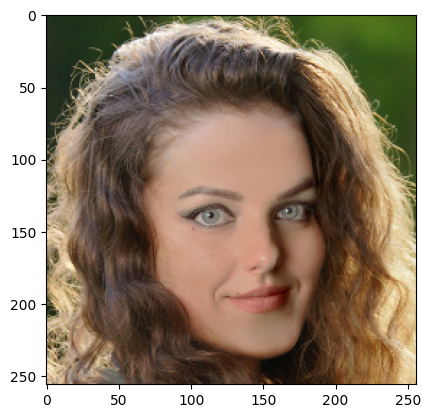

In [43]:
# predicting labels for the batch of images
import numpy as np

for image_batch, label_batch in dataset.take(1):

    first_image = image_batch[0].numpy().astype('uint8')
    first_label = label_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("Actual label : ",class_names[first_label])


    batch_pred = model.predict(image_batch)
    print("Pred label : ",class_names[np.argmax(batch_pred[0])])

In [44]:
# image prediction function using the model
def pred(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 26ms/step


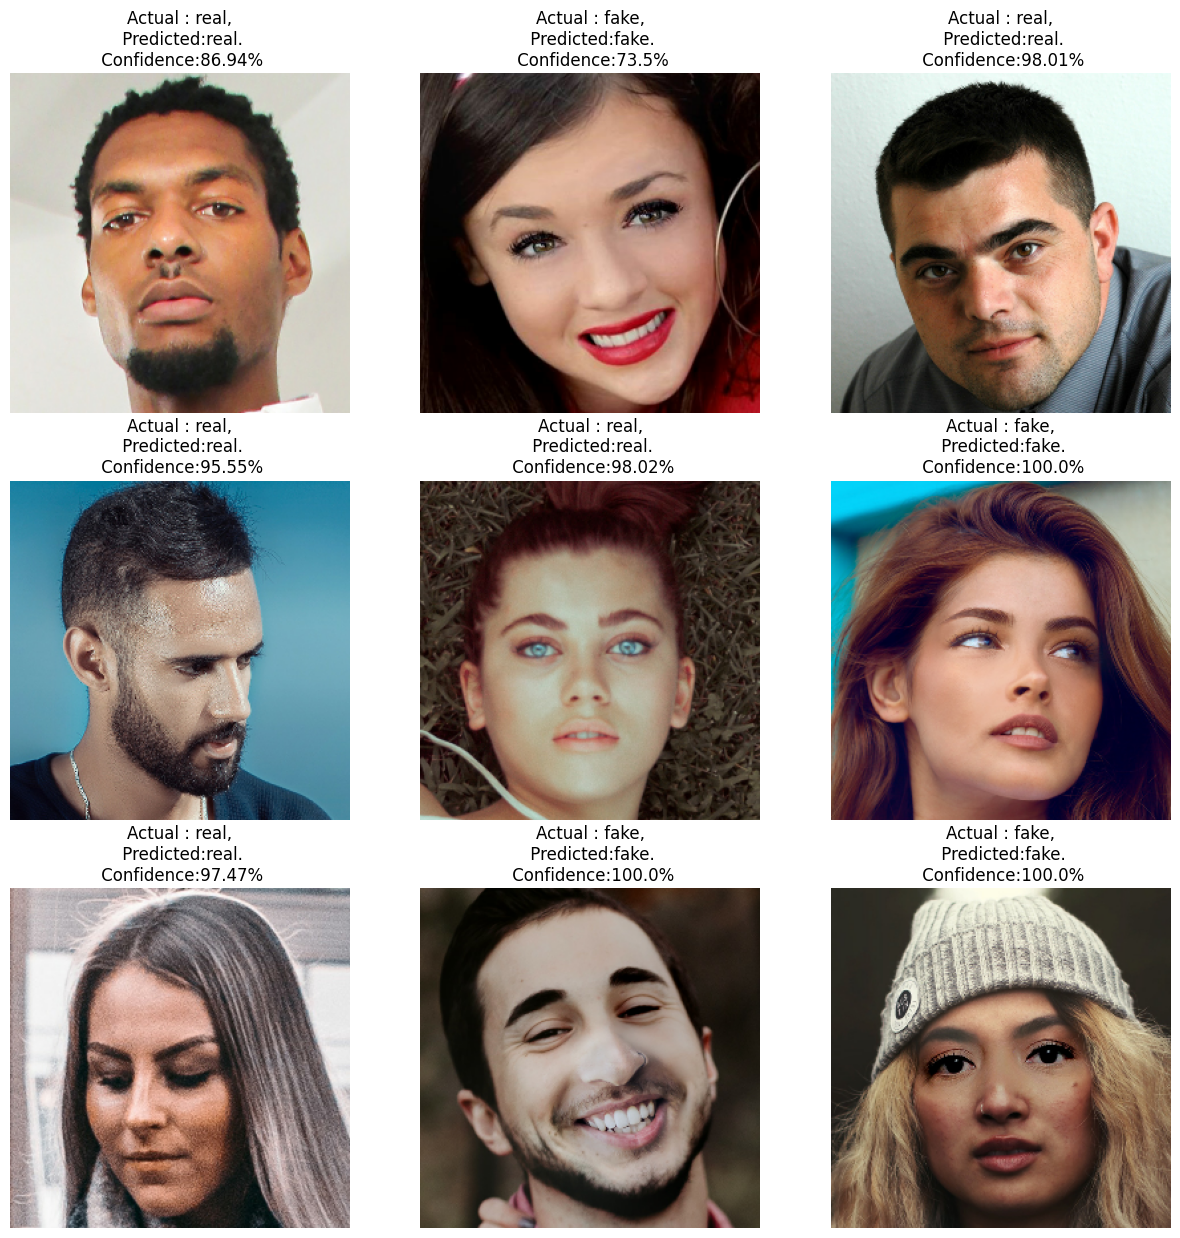

In [45]:
# Displaying Sample Predictions with Confidence
plt.figure(figsize=(15, 15))

for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = pred(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual : {actual_class},\n Predicted:{predicted_class}.\n Confidence:{confidence}%")

        plt.axis("off")

In [50]:
# saving the model
import pickle

with open('model_f_real_pickle','wb') as f:
  pickle.dump(model,f)


In [51]:
# to run the pickle(saved model)
# import pickle

# with open('model_f_real_pickle','rb') as f:
#   model_saved = pickle.load(f)

# to predict the model
# model_saved.predict("give input")


In [52]:
# second method to save the model using joblib
# joblib.dump(model,"model_joblib.pkl")

In [53]:
# to run the model
# classifier = joblib.load('model_joblib.pkl')

# to predict the model
# classifier.predict("give input")